### **SOW-MKI49-2019-SEM1-V: NeurIPS**

# Project: Skeleton Code

In [1]:
%matplotlib notebook

import os
import math
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Categorical
from torch.optim import Adam
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import Neurosmash

In [75]:
data_dir = 'D:/Users/Niels-laptop/Documents/2019-2020/Neural ' \
           'Information Processing Systems/Project/data/'
size = 64

agent = Neurosmash.Agent()
environment = Neurosmash.Environment(size=size)

In [74]:
# source pixel coordinates of corners, determined manually
source_coords = [(32, -2),
                 (-12, 20),
                 (32, 46), 
                 (75, 20)]

# target pixel coordinates of corners, determined by size
target_coords = [(0, 0), 
                 (0, size),
                 (size, size), 
                 (size, 0)]

def find_coeffs(source_coords, target_coords):
    """Finds coefficients needed for perspective transformation.
    
    Args:
        source_coords = [[(int, int)]] list of source x and y pixel coordinates
        target_coords = [[(int, int)]] list of target x and y pixel coordinates
        
    Returns [ndarray]:
        Coefficients as a NumPy ndarray of floats.
    """
    matrix = []
    for s, t in zip(source_coords, target_coords):
        matrix.append([t[0], t[1], 1, 0, 0, 0, -s[0]*t[0], -s[0]*t[1]])
        matrix.append([0, 0, 0, t[0], t[1], 1, -s[1]*t[0], -s[1]*t[1]])
    A = np.matrix(matrix, dtype=np.float)
    B = np.array(source_coords).reshape(8)
    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.array(res).reshape(8)

def transform(image):
    """"Transform the perspective of the image to get a square stage.
    
    Args:
        img = [Image] image of the environment's state
        
    Returns [Image]:
        Perspective transformed image of the square stage.
    """
    coeffs = find_coeffs(source_coords, target_coords)
    return img.transform(image.size, Image.PERSPECTIVE, coeffs, Image.BICUBIC)

In [78]:
def generate_images(nr_images=1000, start_frame=100, image_period=25):
    """Generate images of the environment's state through multiple episodes.
    
    Args:
        nr_picture   = [int] number of images to generate
        start_frame  = [int] number of frames since episode onset
                             before generating new images
        image_period = [int] number of frames before a new
                             image is generated
    """
    while nr_images > 0:
        end, reward, state = environment.reset()

        frame = 0
        while not end and nr_images > 0:
            action = agent.step(end, reward, state)
            end, reward, state = environment.step(action)            
            frame += 1

            if frame > start_frame and frame % image_period == 0:
                img_untransformed = environment.state2image(state)
                img_transformed = transform(img_untransformed)

                img = Image.new('RGB', (size*2, size))
                img.paste(img_transformed, (0, 0))
                img.paste(img_untransformed, (size, 0))

                img_transformed.save('{}{:d}.png'.format(data_dir, nr_images))
                img.save('{}{:d}_label.png'.format(data_dir, nr_images))

                nr_images -= 1

In [ ]:
class LocationsDataset(Dataset):
    """ Dataset housing pairs of game state images and agent locations. """
    
    def __init__(self, images, locations):
        """
        Args:
            images    = [[str]] file names of images
            locations = [[[int]]] 2D array of agent locations
        """
        self.images = images
        self.locations = locations
    
    def __len__(self):
        return len(locations)
        
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        image = Image.open(self.images[index]).convert('RGB')
        image = np.asarray(image, 'f').transpose(2, 0, 1)
        locations = self.locations[index]
        
        return (image, locations)

In [ ]:
def load_data(batch_size=40, train_split=0.64, test_split=0.2):  
    """Load the image and locations data from storage.
    
    Args:
        batch_size  = [int] number of data points in a batch
        train_split = [float] percentage of data that is for training
        test_split  = [float] percentage of data that is for testing
        
    Returns [(DataLoader)]:
        The training, validation, and testing dataloaders. The validation
        split is determined as `1 - train_split - test_split`.
    """
    images = sorted(glob.iglob('{}*.png'.format(data_dir)))
    
    train_split = int(train_split*len(images))
    validation_split = int((1 - test_split)*len(images))
    
    train_images = images[:train_split]
    validation_images = images[train_split:validation_split]
    test_images = images[validation_split:]

    locations = pd.read_csv('{}locations.csv'.format(data_dir)).to_numpy()
    train_locations = locations[:train_split]
    validation_locations = locations[train_split:validation_split]
    test_locations = locations[validation_split:]

    train_set = LocationsDataset(train_images, train_locations)
    validation_set = LocationsDataset(validation_images, validation_locations)
    test_set = LocationsDataset(test_images, test_locations)

    train_iter = DataLoader(train_set, batch_size, shuffle=True)
    validation_iter = DataLoader(validation_set, batch_size, shuffle=False)
    test_iter = DataLoader(test_set, batch_size, shuffle=False)
    
    return train_iter, validation_iter, test_iter

In [ ]:
class SPPLayer(nn.Module):
    """Neural network layer for spatial pyramid pooling.
    
    Attributes:
        nr_levels = [int] height of the pyramid
        pool_type = [str] either `'max_pool'` or `'avg_pool'`
    """
    
    def __init__(self, nr_levels, pool_type='max_pool'):
        super(SPPLayer, self).__init__()

        self.nr_levels = nr_levels
        self.pool_type = pool_type

    def forward(self, x):
        bs, c, h, w = x.size()
        pooling_layers = []
        for i in range(self.nr_levels):
            kernel_size = h // (2 ** i)
            if self.pool_type == 'max_pool':
                tensor = F.max_pool2d(x, kernel_size=kernel_size,
                                      stride=kernel_size).view(bs, -1)
            else:
                tensor = F.avg_pool2d(x, kernel_size=kernel_size,
                                      stride=kernel_size).view(bs, -1)
            pooling_layers.append(tensor)
        x = torch.cat(pooling_layers, dim=-1)
        return x
    
# source: https://gist.github.com/erogol/a324cc054a3cdc30e278461da9f1a05e#file-spp_net-py

In [ ]:
class ConvNet(nn.Module):
    """Implements a Convolutional Neural Network.
    
    Attributes:
        conv1   = [nn.Module] first convolutional layer
        bn1     = [nn.Module] first batch normalization layer
        conv2   = [nn.Module] second convolutional layer
        bn2     = [nn.Module] second batch normalization layer
        conv3   = [nn.Module] third convolutional layer
        bn3     = [nn.Module] third batch normalization layer
        spp     = [nn.Module] spatial pyramid pooling layer
        l1      = [nn.Module] first fully connected layer
        dropout = [nn.Module] dropout layer for generalization
        l2      = [nn.Module] second fully connected layer
    """
    
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1   = nn.Conv2D(3, 32, 5, pad=2)
        self.bn1     = nn.BatchNorm2D(32)
        self.conv2   = nn.Conv2D(32, 64, 5, pad=2)
        self.bn2     = nn.BatchNorm2D(64)
        self.conv3   = nn.Conv2D(64, 128, 5, pad=2)
        self.bn3     = nn.BatchNorm2D(128)
        self.spp     = SPPLayer(3, pool_type='max_pool')
        self.l1      = nn.Linear(128, 1024)
        self.dropout = nn.Dropout2D(p=0.5)
        self.l2      = nn.Linear(1024, 4)
    
    def forward(self, x):
        
        if type(x) is list: # convert state list to tensor
            x = transform(environment.state2image(x))
            x = np.asarray(x, 'f').transpose(2, 0, 1)
            x = torch.tensor(x).unsqueeze(0)
            
        h = F.max_pool2d(F.relu(self.conv1(x)), 3, stride=2)
        h = self.bn1(h)
        h = F.max_pool2d(F.relu(self.conv2(h)), 3, stride=2)
        h = self.bn2(h)
        h = F.relu(self.conv3(h))
        h = self.bn3(h)
        h = self.spp(h)
        h = self.dropout(F.relu(self.l1(h)))
        y = self.l2(h)
        
        return y

In [ ]:
def train_cnn(data_iter, nr_epochs=10):
    """Trains the convolutional neural network on the given data.
    
    Args:
        data_iter = [DataLoader] the iterator that will give image, label pairs
        nr_epochs = [int] number of times the whole data set is sampled
        
    Returns [nn.Module]:
        The trained convolutional neural network.
    """
    model = ConvNet()
    optimizer = Adam(model.parameters())
    criterion = nn.MSELoss()

    for i in range(epochs):
        for batch in data_iter:
            x, t = list(zip(*batch))
            y = model(torch.tensor(x))
            loss = criterion(y, t)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('Training: epoch: {:d}, loss: {:f}'.format(i + 1, loss))
    
    return model

def eval_cnn(cnn, data_iter):
    """Evaluates the convolutional neural network on the given data.
    
    Args:
        cnn       = [nn.Module] the convolutional neural network
        data_iter = [DataLoader] the iterator that will give image, label pairs
    """
    cnn.eval()
    for batch in data_iterator:
        x, t = list(zip(*batch))
        y = model(torch.tensor(x))
        loss = criterion(y, t)
    
        print('Evaluating: loss: {:f}'.format(loss))

<IPython.core.display.Javascript object>


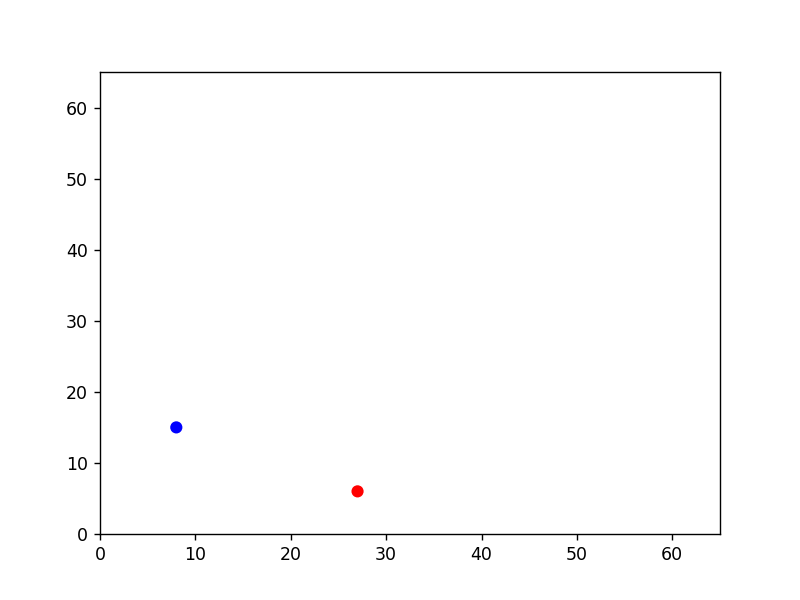

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.ion()
fig.show()
fig.canvas.draw()

def plot_locations(x_red, y_red, x_blue, y_blue):
    """Plots the locations of the agents as a scatterplot.
    
    Args:
        x_red  = [int] x pixel coordinate of red agent
        y_red  = [int] y pixel coordinate of red agent
        x_blue = [int] x pixel coordinate of blue agent
        y_blue = [int] y pixel coordinate of blue agent
    """
    ax.clear()
    ax.scatter([x_red, x_blue], [y_red, y_blue], c=['r', 'b'])
    ax.set_title('Predicted locations of agents')    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(0, size + 1)
    ax.set_ylim(0, size + 1)
    fig.canvas.draw()
    
def test_locations(cnn, nr_episodes=10):
    """Test the convolutional neural network on the real environment.
    
    Args:
        cnn         = [nn.Module] the convolutional neural network
        nr_episdoes = [int] number of episodes to test
    """
    episode = 0
    while episode < nr_episodes:        
        end, reward, state = environment.reset()
        episode += 1
        
        while not end:       
            action = agent.step(end, reward, state)
            end, reward, state = environment.step(action)

            x_red, y_red, x_blue, y_blue = model(state)
            plot_locations(x_red, y_red, x_blue, y_blue)

In [ ]:
models_dir = 'D:/Users/Niels-laptop/Documents/2019-2020/Neural Information ' \
             'Processing Systems/Project/models/'

train_iter, validation_iter, test_iter = load_data()
model = train_cnn(train_iter)
eval_cnn(model, validation_iter)

torch.save(model.state_dict(), '{}cnn.pt'.format(models_dir))
            
test_locations(model)

In [ ]:
diagonal = math.sqrt(size**2 + size**2)
x_center, y_center = size/2, size/2
time_delta = 0.02

# utility functions
def distance(x1, y1, x2, y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def speed(x1, y1, x2, y2):
    return distance(x1, y1, x2, y2) / time_delta

def acceleration(x1, y1, x2, y2, x3, y3):
    speed12 = speed(x1, y1, x2, y2, time_delta)
    speed23 = speed(x2, y2, x3, y3, time_delta)
    return (speed23 - speed12) / (2 * time_delta)

def direction(x1, y1, x2, y2):
    return x2 - x1, y2 - y1

# red agent's extra inputs every frame
def dist_from_center(x, y):
    return distance(x, y, x_center, y_center)

def further_from_center(x_red, y_red, x_blue, y_blue):
    dist_red = dist_from_center(x_red, y_red)
    dist_blue = dist_from_center(x_blue, y_blue)
    return dist_red > dist_blue

def close_to_blue(x_red, y_red, x_blue, y_blue):
    dist_from_blue = distance(x_red, y_red, x_blue, y_blue)
    return dist_from_blue < diagonal / 10

# primitive 'sensor' for losing the game
def danger_index(x_red, y_red, x_blue, y_blue):
    dist_from_center =  dist_from_center(x_red, y_red)
    further_from_center = further_from_center(x_red, y_red, x_blue, y_blue)
    close_to_blue = close_to_blue(x_red, y_red, x_blue, y_blue)
    
    return dist_from_center * further_from_center * close_to_blue

# primitive 'sensor' for winning the game
def opportunity_index(x_red, y_red, x_blue, y_blue)
    dist_from_center =  dist_from_center(x_red, y_red)
    further_from_center = further_from_center(x_red, y_red, x_blue, y_blue)
    close_to_blue = close_to_blue(x_red, y_red, x_blue, y_blue)
    
    return dist_from_center * (1 - further_from_center) * close_to_blue

# primitive 'sensor' for a low-risk, low-reward game state
def safe_index(x_red, y_red)
    return (diagonal / 2) / dist_from_center(x_red, y_red)
    
# aggregate scores for input to MLP
def aggregate(x_red, y_red, x_blue, y_blue):
    return (x_red, y_red, x_blue, y_blue,
            dist_from_center(x_red, y_red),
            dist_from_center(x_blue, y_blue),
            danger_index(x_red, y_red, x_blue, y_blue),
            opportunity_index(x_red, y_red, x_blue, y_blue),
            safe_index(x_red, y_red))


In [ ]:
class MLP(nn.Module):
    """Implements a Multi Layer Perceptron.
    
    Attributes:
        l1      = [nn.Module] input fully connected layer
        dropout = [nn.Module] dropout layer for generalization
        l2      = [nn.Module] output fully connected layer
    """
    
    def __init__(self, n_in, n_hidden, n_out, p=0.5):
        """
        Initializes the MLP.
        
        Args:
            n_in     = [int] number of input units
            n_hidden = [int] number of hidden units
            n_out    = [int] number of output units
            p        = [float] probability for dropout layer
        """
        super(MLP, self).__init__()
        self.l1      = nn.Linear(n_in, n_hidden, bias=False)
        self.dropout = nn.Dropout(p=p)
        self.l2      = nn.Linear(n_hidden, n_out, bias=False)
        
    def forward(self, x):
        h = self.dropout(F.relu(self.l1(x)))
        y = self.l2(h)
        return y

In [ ]:
class Memory(object):
    """Implements memory that is used as Replay Memory to increase 
       Q learning stability and as Episode Memory to store action 
       probabilities and rewards for Policy Gradient.
    
    Attributes:
        capacity = [int] the maximum number of elements in the memory
        memory   = [list] the actual collection of memories
        position = [int] the index at which a new elment can be stored
    """
    
    def __init__(self, capacity):
        """Initializes the memory with a given capacity.
        
        Args:
            capacity = [int] the maximum number of elements in the memory
        """
        self.capacity = capacity
        self.reset()
        
    def reset(self):
        """Unload the elements in the memory and reset the pointer."""
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        """Saves a new element.
        
        Args:
            see environment
        """
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = args
            
        self.position = (self.position + 1) % self.capacity
        
    def take_all(self):
        """Take all available elements.
        
        Returns [list]:
            All the available elements in list format, transposed.
        """
        return list(zip(*self.memory))
        
    def sample(self, batch_size):
        """Take a random sample of the available elements.
        
        Args:
            batch_size = [int] the number of elements to be sampled
            
        Returns [list]:
            batch_size randomly sampled elements from the memory, transposed.
        """
        elements = random.sample(self.memory, batch_size)
        return list(zip(*elements))
    
    def __len__(self):
        """Returns current number of elements in the memory."""
        return len(self.memory)

In [ ]:
class PGAgent(object):
    """Implements a Neural Policy Gradient Agent.
    
    Attributes:
        model       = [nn.Module] model that is updated every episode
        optimizer   = [Optimizer] optimizer used to train the model
        y           = [float] the gamma parameter for computing Q values
        memory      = [ReplayMemory] stores (action probability, reward) pairs
    """
    
    def __init__(self):
        # setup the policy and target neural networks
        self.model = MLP(9, 128, 3)
        
        # setup an optimizer
        self.optimizer = Adam(self.model.parameters(), lr=0.01)
        
        # set Q learning parameters
        self.y = 0.99  # gamma

        # setup Episode Memory
        self.memory = Memory(512)
        
    def step(self, state):
        """Agent determines the action based on the current state and model.
        
        Args:
            state = [object] current state of the environment
            
        Returns [int]:
            Action in the range [0, 3).
        """
        # apply neural network to get action distribution
        x = torch.tensor(state)
        action_probs = F.softmax(self.model(x), dim=-1)
        
        # sample from action distribution to get action
        action_distr = Categorical(action_probs)
        action = action_distr.sample()
    
        return action
    
    def train(self, end, action, old_state, reward, new_state):
        """Trains agent based on last action + state and new reward + state.
        
        Args:
           end       = [bool] whether the episode has finished
           action    = [int] action as int in the range [0, 3)
           old_state = [object] previous state of the environment
           reward    = [int] reward received after doing action in old_state
           new_state = [object] the state of the environment after doing
                                action in old_state
        """        
        # apply neural network to get action distribution
        x = torch.tensor(old_state)
        action_probs = F.softmax(self.model(x), dim=-1)
        
        # compute log probability of sampled action
        action_log_prob = action_probs[action].log()
        
        # add action log probability and reward to memory
        self.memory.push(action_log_prob, reward)
              
        if not end:  # episode is not yet done
            return
        
        # get all the log probabilities and rewards of this episode
        minibatch = self.memory.take_all()
        
        # unpack minibatch
        action_log_prob_batch = torch.stack(minibatch[0])
        reward_batch = minibatch[1]
        
        # compute Q values for each step in the episode
        Q_values = torch.zeros(len(reward_batch))
        Q_values[-1] = reward_batch[-1]
        for i in range(len(Q_values) - 1, 0, -1):
            Q_values[i - 1] = reward_batch[i - 1] + self.y * Q_values[i]

        # compute loss        
        loss = -1 * torch.sum(action_log_prob_batch * Q_values)

        # update model parameters
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # reset Episode Memory
        self.memory.reset()

In [ ]:
def run_agent(env, agent, epsilon_start=0.95, epsilon_decay=0.995,
              epsilon_min=0.005, n_episodes=1000, train=True):
    """Function to run the agent for a given number of episodes.
    
    Args:
        epsilon_start = [float] starting value for exploration/
                                exploitation parameter
        epsilon_decay = [float] number signifying how fast epsilon decreases
        epsilon_min   = [float] minimal value for the epsilon parameter
        n_episodes    = [int] number of episodes the agent will learn for
        train         = [bool] whether to update the agent's model's parameters
    """    
    R = []  # keep track of rewards
    epsilon = epsilon_start  # initialize epsilon
    for i_episode in range(n_episodes):  # loop over episodes
        
        # add element to rewards list
        R.append(0)
        
        # reset environment, create first observation
        end, reward, old_state = env.reset()
        x_red, y_red, x_blue, y_blue = cnn(old_state)
        old_state = aggregate(x_red, y_red, x_blue, y_blue)
        while not end:

            # choose an action
            if random.random() < epsilon:
                # random actions to explore environment (exploration)
                action = random.randrange(3) 
            else:
                # strictly follow currently learned behaviour (exploitation)
                action = agent.step(old_state)

            # do action, get reward, and a new observation for the next round
            end, reward, new_state = env.step(action)
            x_red, y_red, x_blue, y_blue = cnn(new_state)
            new_state = aggregate(x_red, y_red, x_blue, y_blue)
                
            if train:  # adjust agent model's parameters (training step)
                agent.train(end, action, old_state, reward, new_state)

            # update state variable
            old_state = new_state

            # track the rewards
            R[i_episode] += reward

            # decay epsilon parameter
            epsilon = max(epsilon_min, epsilon * epsilon_decay)

In [ ]:
# load cnn from storage
cnn = ConvNet()
cnn.load_state_dict(torch.load('{}cnn.pt'.format(models_dir)))
cnn.eval()

# create environment
environment = Neurosmash.Environment()

# create agents
pg_agent = PGAgent()

# run agents
run_agent(env, pg_agent, n_episodes=200)

# save Policy Gradient agent's model to disk
torch.save(pg_agent.model.state_dict(), os.path.join(models_dir, 'mlp.pt'))